# Kolton Baldwin 
## 09/15/2024

# Pluralsight Data Science Take Home Challenge

A short data science project used to assess a candidate's critical-thinking, Python 3 coding, data cleaning, and applied analysis skills.

## TIME
*  A candidate with 3 years of hands-on experience in data science should be able to complete this challenge in ~2 hours.
*  There is NO time limit. Candidates may spend as much time as they want on the challenge before submitting it.

## SUBMISSION REQUIREMENTS
A solution submission must be...
*  Written in Python 3.
*  Shared via GitLab, GitHub, or Binder.
*  Include a fully-executed Jupyter notebook.  For security reasons, we will not be running any submitted code.
*  Include predictions for all 20 cases in the `_zeta-disease_prediction-data_` dataset.
*  Complete when it is submitted.  We will only score the first submission.
*  The candidate's own, original work.  Evidence of plagiarism will be grounds for rejecting the submission.

## THE CHALLENGE: Zeta Disease Prediction

### INTRODUCTION

Mars Mission Control needs a good data-driven system for predicting Zeta Disease infection on the International Mars Colony.
Use the `_zeta-disease_training-data_` dataset to build a model that can predict who will be infected by Zeta Disease.
Apply your model to the `_zeta-disease_prediction-data_` dataset to predict who will be infected by Zeta Disease.

### DATASET

The dataset includes 9 columns with information on 800 people.
1.	age : in years
2.	weight : body weight in pounds (lbs)
3.	bmi : Body Mass Index (weight in kg/(height in m)2)
4.	blood_pressure : resting blood pressure (mm Hg)
5.	insulin_test : inuslin test value
6.	liver_stress_test : liver_stress_test value
7.	cardio_stress_test : cardio_stress_test value
8.	years_smoking : number of years of smoking
9.	zeta_disease :
              1 = yes;
              0 = no


## Data exploration and cleaning

In [1]:
from itertools import product
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer 
from sklearn.model_selection import train_test_split

In [2]:
population_data = pd.read_excel('recruiting_zeta-disease_training-data_take-home-challenge.xlsx')
population_data_disease = population_data.loc[:, ['zeta_disease']].copy()
population_data = population_data.loc[:, [k for k in population_data.columns if k != 'zeta_disease']].copy()

untested_population_data = pd.read_excel('recruiting_zeta-disease_prediction-data_take-home-challenge (1).xlsx')
untested_population_data = untested_population_data.drop('zeta_disease', axis=1)

In [3]:
population_data.shape

(800, 8)

In [4]:
untested_population_data.shape

(20, 8)

In [5]:
population_data.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
0,54.0,189.0,27.1,80.0,0.0,1.5038,0.0,10.0
1,23.0,150.0,38.5,68.0,71.0,0.3868,55.0,2.0
2,47.0,186.0,29.9,90.0,0.0,0.2728,0.0,7.0
3,18.0,150.0,30.8,70.0,1033.0,0.6598,56.0,0.0
4,24.0,160.0,32.4,74.0,125.0,0.7608,59.0,2.0


In [6]:
untested_population_data.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
0,24.0,151.0,39.5,69.0,72.0,1.3968,56.0,4.0
1,27.0,179.0,35.5,89.0,156.0,1.6608,43.0,6.0
2,34.0,147.0,26.9,76.0,74.0,1.6958,53.0,2.0
3,35.0,206.0,32.4,73.0,127.0,1.4608,61.0,6.0
4,60.0,193.0,29.8,62.0,192.0,1.7798,65.0,9.0


In [7]:
population_avg = population_data.mean()
population_avg

age                    30.985000
weight                172.407500
bmi                    32.201625
blood_pressure         69.565000
insulin_test           85.887500
liver_stress_test       0.544496
cardio_stress_test     43.121250
years_smoking           4.051250
dtype: float64

In [8]:
population_data.min()

age                   18.0000
weight                94.0000
bmi                    0.0000
blood_pressure         0.0000
insulin_test           0.0000
liver_stress_test      0.1408
cardio_stress_test     0.0000
years_smoking          0.0000
dtype: float64

In [9]:
population_data.max()

age                    109.0000
weight                 308.0000
bmi                     86.1000
blood_pressure         157.0000
insulin_test          1077.0000
liver_stress_test        3.4813
cardio_stress_test     214.0000
years_smoking           40.0000
dtype: float64

In [10]:
(population_data == 0).sum()

age                     0
weight                  0
bmi                    11
blood_pressure         35
insulin_test          370
liver_stress_test       0
cardio_stress_test    227
years_smoking         114
dtype: int64

It seems reasonable to fill in missing values with good approximations from data points that are the most similar.  Of course it is reasonable that someone does not smoke so that a value of zero years smoking is appropriate, however it other fields like BMI, blood pressure, etc. should reasonably be non-zero only.

We impute missing values with the average value of the k-nearest neighbors (IE the average value of the field among those patients most similar to the person with the missing data point). We choose to include indicator columns where missing values because some missing values may actually indicate either health or illness.  Consider, for example, that a doctor may not order a liver stress test if the patient is already diagnosed with zeta disease through other means.  This approach gives us balance between needing reliable measurements and allowing for accurate representation of the diagnosis process.  

In [11]:
imputer = KNNImputer(missing_values=0, 
                     n_neighbors=5, 
                     add_indicator=True)
imputed_population_data = imputer.fit_transform(population_data.drop('years_smoking', axis=1))
columns = imputer.feature_names_in_
columns = list(columns) + [k + '_missing' for k in columns[list(imputer.indicator_.features_)]]
imputed_population_data = pd.DataFrame(imputed_population_data, columns=columns)
imputed_population_data.loc[:, 'years_smoking'] = population_data.loc[:, 'years_smoking'].copy()

imputed_population_data.loc[:, 'const'] = np.ones(imputed_population_data.shape[0])
train_X, test_X, train_y, test_y = train_test_split(imputed_population_data, population_data_disease, train_size=0.7) 

imputed_population_data.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,bmi_missing,blood_pressure_missing,insulin_test_missing,cardio_stress_test_missing,years_smoking,const
0,54.0,189.0,27.1,80.0,204.0,1.5038,52.6,0.0,0.0,1.0,1.0,10.0,1.0
1,23.0,150.0,38.5,68.0,71.0,0.3868,55.0,0.0,0.0,0.0,0.0,2.0,1.0
2,47.0,186.0,29.9,90.0,205.8,0.2728,60.6,0.0,0.0,1.0,1.0,7.0,1.0
3,18.0,150.0,30.8,70.0,1033.0,0.6598,56.0,0.0,0.0,0.0,0.0,0.0,1.0
4,24.0,160.0,32.4,74.0,125.0,0.7608,59.0,0.0,0.0,0.0,0.0,2.0,1.0


In [12]:
imputed_untested_population_data = imputer.fit_transform(untested_population_data.drop('years_smoking', axis=1))
columns = imputer.feature_names_in_
columns = list(columns) + [k + '_missing' for k in columns[list(imputer.indicator_.features_)]]
imputed_untested_population_data = pd.DataFrame(imputed_untested_population_data, columns=columns)
imputed_untested_population_data.loc[:, 'years_smoking'] = untested_population_data.loc[:, 'years_smoking'].copy()
imputed_untested_population_data.loc[:, 'const'] = np.ones(imputed_untested_population_data.shape[0])
imputed_untested_population_data.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,const
0,24.0,151.0,39.5,69.0,72.0,1.3968,56.0,4.0,1.0
1,27.0,179.0,35.5,89.0,156.0,1.6608,43.0,6.0,1.0
2,34.0,147.0,26.9,76.0,74.0,1.6958,53.0,2.0,1.0
3,35.0,206.0,32.4,73.0,127.0,1.4608,61.0,6.0,1.0
4,60.0,193.0,29.8,62.0,192.0,1.7798,65.0,9.0,1.0


In [13]:
# the untested dataset wasn't missing any values, so we'll have to manually add columns of zeros
cols_to_add = [col for col in imputed_population_data.columns if col not in imputed_untested_population_data.columns]
imputed_untested_population_data.loc[:, cols_to_add] = 0 
imputed_untested_population_data = imputed_untested_population_data.loc[:, imputed_population_data.columns]

In [14]:
imputed_untested_population_data.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,bmi_missing,blood_pressure_missing,insulin_test_missing,cardio_stress_test_missing,years_smoking,const
0,24.0,151.0,39.5,69.0,72.0,1.3968,56.0,0,0,0,0,4.0,1.0
1,27.0,179.0,35.5,89.0,156.0,1.6608,43.0,0,0,0,0,6.0,1.0
2,34.0,147.0,26.9,76.0,74.0,1.6958,53.0,0,0,0,0,2.0,1.0
3,35.0,206.0,32.4,73.0,127.0,1.4608,61.0,0,0,0,0,6.0,1.0
4,60.0,193.0,29.8,62.0,192.0,1.7798,65.0,0,0,0,0,9.0,1.0


In [15]:
imputed_population_data.loc[:, 'const'] = np.ones(imputed_population_data.shape[0])
train_X, test_X, train_y, test_y = train_test_split(imputed_population_data, population_data_disease, train_size=0.7) 

## Random Forest

In [16]:
best_params = 'defaults'
best_oob = 0 
print('initial oob score: ', best_oob)

n_estimators = [50, 100, 150, 200, 500]
max_depths = [k for k in range(1, 12)]
max_features = [1, 3, 'sqrt', 'log2']

for num_trees, depth, n_features in product(n_estimators, max_depths, max_features):
    random_forest = RandomForestClassifier(n_estimators=num_trees,
                                           max_depth=depth,
                                           max_features=n_features, 
                                           oob_score=True,
                                           warm_start=False, 
                                           
                                          )
    random_forest.fit(train_X, np.ravel(train_y))
    oob = random_forest.oob_score_
    if oob > best_oob:
        best_oob = oob 
        best_params = {'n_estimators':num_trees,
                      'max_depth':depth,
                      'max_features':n_features}
        print('best_oob', best_oob)

print('best oob score: ', best_oob)
print('best parameters: ', best_params)

initial oob score:  0
best_oob 0.6339285714285714
best_oob 0.7053571428571429
best_oob 0.7392857142857143
best_oob 0.7625
best_oob 0.7678571428571429
best_oob 0.7767857142857143
best_oob 0.7857142857142857
best_oob 0.7875
best_oob 0.7928571428571428
best oob score:  0.7928571428571428
best parameters:  {'n_estimators': 150, 'max_depth': 11, 'max_features': 'log2'}


## Logistic Regression

In [17]:
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score

In [26]:
mod = Logit(np.ravel(train_y), train_X).fit_regularized(method='l1_cvxopt_cp', alpha=1)

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  6.9315e-01  3e+01  1e+00  1e+00
 1:  5.7484e-01 -4.7124e-02  1e+00  8e-02  9e-02
 2:  7.8961e-01  5.6816e-01  4e-01  3e-02  3e-02
 3:  7.0559e-01  9.6435e-01  2e-01  8e-02  1e-01
 4:  1.0802e+00  1.0326e+00  4e-02  2e-03  2e-02
 5:  1.0482e+00  8.3230e-01  7e-03  4e-02  1e-03
 6:  8.9360e-01  7.7635e-01  2e-03  2e-02  3e-04
 7:  8.3504e-01  7.7346e-01  2e-03  1e-02  2e-04
 8:  7.8936e-01  7.6023e-01  5e-04  5e-03  4e-05
 9:  7.6956e-01  7.5759e-01  2e-04  2e-03  1e-05
10:  7.5993e-01  7.5661e-01  4e-05  6e-04  3e-06
11:  7.5761e-01  7.5651e-01  2e-05  2e-04  9e-07
12:  7.5670e-01  7.5649e-01  4e-06  4e-05  2e-07
13:  7.5652e-01  7.5649e-01  5e-07  6e-06  3e-08
14:  7.5649e-01  7.5649e-01  2e-08  2e-07  1e-09
15:  7.5649e-01  7.5649e-01  2e-10  3e-10  1e-11
Optimal solution found.


In [27]:
accuracy_score(np.ravel(test_y), np.round(mod.predict(test_X.values)))

0.8041666666666667

In [28]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  560
Model:                          Logit   Df Residuals:                      549
Method:                           MLE   Df Model:                           10
Date:                Sun, 15 Sep 2024   Pseudo R-squ.:                  0.2669
Time:                        19:43:15   Log-Likelihood:                -269.66
converged:                       True   LL-Null:                       -367.83
Covariance Type:            nonrobust   LLR p-value:                 9.406e-37
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
age                            0.0134      0.009      1.519      0.129      -0.004       0.031
weight                         0.0300      0.004      7.307      0.000       0.022       0.038
bmi                            0.0720      0.017      4.222      0.000       0.039       0.105
blood_pressure                -0.0006      0.008     -0.070      0.945      -0.017       0.016
insulin_test                  -0.0004      0.001     -0.388      0.698      -0.002       0.002
liver_stress_test              0.9822      0.327      3.008      0.003       0.342       1.622
cardio_stress_test             0.0076      0.007      1.040      0.298      -0.007       0.022
bmi_missing                         0        nan        nan        nan         nan         nan
blood_pressure_missing         0.2371      0.476      0.499      0.618      -0.695       1.169
insulin_test_missing           0.4419      0.227      1.950      0.051      -0.002       0.886
cardio_stress_test_missing          0        nan        nan        nan         nan         nan
years_smoking                  0.0589      0.026      2.284      0.022       0.008       0.109
const                         -9.9998      1.011     -9.895      0.000     -11.981      -8.019
==============================================================================================
"""

### Iteratively removing insignificant features

In [29]:
drops = pd.Series(index=mod.pvalues.index, data=False)
scores = []
best_logit_mod = mod
best_logit_score = accuracy_score(np.ravel(test_y), np.round(best_logit_mod.predict(test_X.values)))
best_logit_drops = drops.copy() 
while (mod.pvalues > 0.1).any():
    
    to_remove = mod.pvalues.index[mod.pvalues.argmax()]
    drops.loc[to_remove] = True 
    print(f'removing {to_remove} from features (previous pval={mod.pvalues[to_remove]})')
    print(drops)
    
#     mod = Logit(np.ravel(train_y), train_X.loc[:, ~drops]).fit()
    mod = Logit(np.ravel(train_y), train_X.loc[:, ~drops]).fit_regularized(method='l1_cvxopt_cp', alpha=1)
    score = accuracy_score(np.ravel(test_y), np.round(mod.predict(test_X.loc[:, ~drops].values)))    
    scores.append(score)
    if score > best_logit_score:
        best_logit_mod = mod
        best_logit_score = score 
        best_logit_drops = drops.copy() 
    print(f'the new model had a score of {score}')
    print('\n')

removing blood_pressure from features (previous pval=0.944569546150335)
age                           False
weight                        False
bmi                           False
blood_pressure                 True
insulin_test                  False
liver_stress_test             False
cardio_stress_test            False
bmi_missing                   False
blood_pressure_missing        False
insulin_test_missing          False
cardio_stress_test_missing    False
years_smoking                 False
const                         False
dtype: bool
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  6.9315e-01  2e+01  1e+00  1e+00
 1:  6.1849e-01  5.8333e-02  9e-01  7e-02  6e-02
 2:  7.6252e-01  5.0012e-01  4e-01  3e-02  3e-02
 3:  6.3246e-01  8.6080e-01  2e-01  9e-02  2e-01
 4:  9.9971e-01  9.7609e-01  5e-02  4e-03  2e-02
 5:  1.0007e+00  8.2644e-01  9e-03  3e-02  2e-03
 6:  8.6089e-01  7.5290e-01  2e-03  2e-02  3e-04
 7:  7.9797e-01  7.4898e-01  1e-03  9e-03  1e-04
 8:  7.5

In [30]:
best_logit_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  560
Model:                          Logit   Df Residuals:                      549
Method:                           MLE   Df Model:                           10
Date:                Sun, 15 Sep 2024   Pseudo R-squ.:                  0.2669
Time:                        19:43:24   Log-Likelihood:                -269.66
converged:                       True   LL-Null:                       -367.83
Covariance Type:            nonrobust   LLR p-value:                 9.406e-37
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
age                            0.0134      0.009      1.519      0.129      -0.004       0.031
weight                         0.0300      0.004      7.307      0.000       0.022       0.038
bmi                            0.0720      0.017      4.222      0.000       0.039       0.105
blood_pressure                -0.0006      0.008     -0.070      0.945      -0.017       0.016
insulin_test                  -0.0004      0.001     -0.388      0.698      -0.002       0.002
liver_stress_test              0.9822      0.327      3.008      0.003       0.342       1.622
cardio_stress_test             0.0076      0.007      1.040      0.298      -0.007       0.022
bmi_missing                         0        nan        nan        nan         nan         nan
blood_pressure_missing         0.2371      0.476      0.499      0.618      -0.695       1.169
insulin_test_missing           0.4419      0.227      1.950      0.051      -0.002       0.886
cardio_stress_test_missing          0        nan        nan        nan         nan         nan
years_smoking                  0.0589      0.026      2.284      0.022       0.008       0.109
const                         -9.9998      1.011     -9.895      0.000     -11.981      -8.019
==============================================================================================
"""

### examining whether shifting the threshold to classify as a positive affects accuracy 

In [31]:
test_threshold = lambda threshold: accuracy_score(np.ravel(test_y), (best_logit_mod.predict(test_X.loc[:, ~best_logit_drops].values) > threshold).astype(int))

In [32]:
from matplotlib import pyplot as plt 

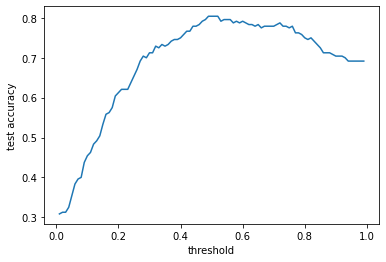

In [33]:
threshholds = np.linspace(0.01, 0.99, 99)
plt.plot(threshholds, [test_threshold(th) for th in threshholds])
plt.ylabel('test accuracy')
plt.xlabel('threshold')
plt.show()

In [34]:
max([test_threshold(th) for th in threshholds])

0.8041666666666667

In [36]:
best_logit_threshhold = threshholds[np.argmax([test_threshold(th) for th in threshholds])]
best_logit_threshhold

0.49

## K-Nearest Neighbors

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [72]:
knn = KNeighborsClassifier()
knn.fit(train_X, np.ravel(train_y))

KNeighborsClassifier()

In [73]:
accuracy_score(np.ravel(test_y), knn.predict(test_X))

0.7125

## Compile test data results

In [43]:
preds = (best_logit_mod.predict(test_X.loc[:, ~best_logit_drops].values) > best_logit_threshhold)
df = pd.DataFrame(index=test_X.index, columns=['preds', 'actuals'], data=np.array([preds, np.ravel(test_y)]).T)
df.loc[:, 'probs'] = best_logit_mod.predict(test_X.loc[:, ~best_logit_drops]).values
df.loc[:, 'rf_preds'] = random_forest.predict(test_X)
df.loc[:, 'rf_probs'] = random_forest.predict_proba(test_X).max(axis=1)
df.loc[:, 'knn_preds'] = knn.predict(test_X)
df.loc[:, 'knn_probs'] = knn.predict_proba(test_X).max(axis=1)

## Compile predictions for twenty unknown cases

In [52]:
untested_df = pd.DataFrame(index=untested_population_data.index)
untested_df.loc[:, 'logit_probs'] = best_logit_mod.predict(imputed_untested_population_data.loc[:,~best_logit_drops].values)
untested_df.loc[:, 'logit_preds'] = (untested_df.loc[:, 'logit_probs'] > best_logit_threshhold).astype(int)
untested_df.loc[:, 'rf_preds'] = random_forest.predict(imputed_untested_population_data)
untested_df.loc[:, 'rf_probs'] = random_forest.predict_proba(imputed_untested_population_data).max(axis=1)
untested_df.loc[:, 'knn_preds'] = knn.predict(imputed_untested_population_data)
untested_df.loc[:, 'knn_probs'] = knn.predict_proba(imputed_untested_population_data).max(axis=1)

In [53]:
untested_df

,logit_probs,logit_preds,rf_preds,rf_probs,knn_preds,knn_probs
0,0.417368,0,0.0,0.576695,0.0,0.6
1,0.620662,1,1.0,0.582002,0.0,0.8
2,0.253689,0,0.0,0.749986,0.0,0.8
3,0.759345,1,1.0,0.752945,0.0,0.6
4,0.803240,1,1.0,0.595605,1.0,0.6
5,0.298394,0,0.0,0.586000,0.0,1.0
6,0.348724,0,0.0,0.658047,0.0,1.0
7,0.241019,0,0.0,0.613596,0.0,1.0
8,0.661887,1,1.0,0.710393,0.0,0.6
9,0.538404,1,0.0,0.772000,0.0,0.8


In [75]:
use_rf_knn_idx = untested_df.loc[  (untested_df.logit_preds != untested_df.rf_preds)
                                 & (untested_df.logit_preds != untested_df.knn_preds)]
use_rf_knn_idx

,logit_probs,logit_preds,rf_preds,rf_probs,knn_preds,knn_probs
9,0.538404,1,0.0,0.772,0.0,0.8


In [76]:
use_rf_knn_idx = use_rf_knn_idx.index

We accept the logistic regression results (which has the best test accuracy out of the included models) except in the case that both the random forest and the k-nearest neighbor classifiers disagree with the logistic regression results.  Our final predictions are given below (in the zeta_disease column):

## Results

In [80]:
untested_population_data.loc[:, 'zeta_disease'] = untested_df.loc[:, 'logit_preds']
untested_population_data.loc[use_rf_knn_idx, 'zeta_disease'] = untested_df.loc[:, 'rf_preds']
untested_population_data

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24.0,151.0,39.5,69.0,72.0,1.3968,56.0,4.0,0
1,27.0,179.0,35.5,89.0,156.0,1.6608,43.0,6.0,1
2,34.0,147.0,26.9,76.0,74.0,1.6958,53.0,2.0,0
3,35.0,206.0,32.4,73.0,127.0,1.4608,61.0,6.0,1
4,60.0,193.0,29.8,62.0,192.0,1.7798,65.0,9.0,1
5,45.0,120.0,36.5,108.0,50.0,1.2978,54.0,12.0,0
6,20.0,139.0,38.2,61.0,77.0,1.5818,68.0,3.0,0
7,23.0,137.0,31.2,70.0,73.0,1.4168,59.0,7.0,0
8,36.0,195.0,30.5,59.0,141.0,1.4498,59.0,6.0,1
9,19.0,193.0,25.8,84.0,66.0,1.7938,50.0,3.0,0
